Workflow is given by "Roland CTR" and "Roland SIN6" (13 sce, 23 ltree)

In [1]:
library(RaceID)

Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”Warning message:
“'rgl_init' failed, running with rgl.useNULL = TRUE”

In [164]:
sin.sc <- readRDS('/extra//schule//galaxy_history/rolsin6.13.rdata')
#sin.ltree <- readRDS('/extra//schule//galaxy_history/rolsin6.23.ltree.rds')

# Annotate

To do expression map plotting, we need to annotate transcripts to their external gene names.

In [165]:
sin.names <- rownames(getfdata(sin.sc))

In [17]:
library(biomaRt)

In [18]:
mart <- useMart(biomart = "ENSEMBL_MART_ENSEMBL")

In [30]:
# Find homo sapians
tab <- listDatasets(mart)
head(tab)
tab[grepl("sap", tab$dataset),]

dataset                      description                          
1 abrachyrhynchus_gene_ensembl Pink-footed goose genes (ASM259213v1)
2 acalliptera_gene_ensembl     Eastern happy genes (fAstCal1.2)     
3 acarolinensis_gene_ensembl   Anole lizard genes (AnoCar2.0)       
4 acitrinellus_gene_ensembl    Midas cichlid genes (Midas_v5)       
5 ahaastii_gene_ensembl        Great spotted kiwi genes (aptHaa1)   
6 amelanoleuca_gene_ensembl    Panda genes (ailMel1)                
  version    
1 ASM259213v1
2 fAstCal1.2 
3 AnoCar2.0  
4 Midas_v5   
5 aptHaa1    
6 ailMel1

dataset               description              version   
73 hsapiens_gene_ensembl Human genes (GRCh38.p12) GRCh38.p12

In [35]:
mart <- useMart(biomart = "ENSEMBL_MART_ENSEMBL", 
                host = "www.ensembl.org",
                dataset = "hsapiens_gene_ensembl")

# Find attributes
#listAttributes(mart)

In [36]:
# Just the filtered genes
k.filt <- getBM(
    filters = "ensembl_gene_id",
    attributes = c(
            "ensembl_gene_id",  
            "external_gene_name"
    ),
    values = sin.names,
    mart = mart
)

In [166]:
# Full set
k <- getBM(
    filters = "ensembl_gene_id",
    attributes = c(
            "ensembl_gene_id",  
            "external_gene_name"
    ),
    values = rownames(sin.sc@expdata),
    mart = mart
)

In [51]:
head(k.filt)

# No duplicates, can perform direct rename
anyDuplicated(k.filt$ensembl_gene_id)
anyDuplicated(k.filt$external_gene_name)

# But difference of 3 missing transcripts...
length(rownames(getfdata(sin.sc)))
length(k.filt$external_gene_name)
length(k.filt$ensembl_gene_id)

ensembl_gene_id external_gene_name
1 ENSG00000001461 NIPAL3            
2 ENSG00000004455 AK2               
3 ENSG00000004487 KDM1A             
4 ENSG00000008130 NADK              
5 ENSG00000009307 CSDE1             
6 ENSG00000010165 EEF1AKNMT

[1] 0

[1] 0

[1] 4540

[1] 4537

[1] 4537

In [59]:
# which 3 are missing?
chek <- rownames(getfdata(sin.sc))

sum(!(chek %in% k$ensembl_gene_id))
chek[(!(chek %in% k$ensembl_gene_id))]

# ENSG00000274877 not in current ensembl
# ENSG00000205664 not in current ensembl
# ENSG00000154537 not in current ensembl

[1] 3

[1] "ENSG00000274877" "ENSG00000205664" "ENSG00000154537"

In [167]:
### Full set ###
head(k)

# No duplicates, can perform direct rename
anyDuplicated(k$ensembl_gene_id)
anyDuplicated(k$external_gene_name)

# But difference of 5326 duplicates....
length(rownames(sin.sc@expdata))
length(k$external_gene_name)
length(k$ensembl_gene_id)

ensembl_gene_id external_gene_name
1 ENSG00000004487 KDM1A             
2 ENSG00000007923 DNAJC11           
3 ENSG00000007968 E2F2              
4 ENSG00000008128 CDK11A            
5 ENSG00000008130 NADK              
6 ENSG00000009709 PAX7

[1] 0

[1] 5326

[1] 33694

[1] 33061

[1] 33061

In [171]:
dupes <- k$external_gene_name[duplicated(k$external_gene_name)]
dupes

[1] "LINC01238" "MATR3"     "TMSB15B"   "PINX1"     "LINC01505" "ITFG2-AS1"
[7] "ATF7"      "GOLGA8M"

In [74]:
# Remove them from analysis
good.names <- chek[chek %in% k$ensembl_gene_id]
length(good.names)

dim(getfdata(sin.sc))
sin.sc.good <- getfdata(sin.sc, g = good.names)
class(sin.sc.good)

[1] 4537

[1] 4540 4515

[1] "matrix"

In [124]:
## Surprisingly hard to change the names of the existing object
## Instead, because the dimensions of expdata and ndata are the same
## we will just directly replace the names and not update the 3
## transcripts

# Small working implementatation
r <- c("b","c","a","e","d")

z <- data.frame(
    num=c("a","b","c","d"),
    wrd=c("one","two","three","four")
)
z

n <- c()

for (x in r){
    res <- z[z$num == x,]$wrd
    if (length(res) > 0){
        n <<- c(n, as.character(res))
    }
    else {
        n <<- c(n, x)
    }
}
n


num wrd  
1 a   one  
2 b   two  
3 c   three
4 d   four

[1] "two"   "three" "one"   "e"     "four"

In [172]:
# Actual switch
new.names <- c()

for (x in rownames(sin.sc@expdata)){
    res <- k[k$ensembl_gene_id == x,]$external_gene_name
    if (length(res) > 0){
        res2 <- as.character(res)
        # Don't update duplicates
        if (!(res2 %in% dupes)){
            new.names <<- c(new.names, as.character(res2))
        }
        else {
            new.names <<- c(new.names, x)
        }        
    }
    else {
        new.names <<- c(new.names, x)
    }
}

#head(sin.names)
head(new.names)

length(rownames(sin.sc@expdata))
length(new.names)

[1] "MIR1302-2HG" "FAM138A"     "OR4F5"       "AL627309.1"  "AL627309.3" 
[6] "AL627309.2"

[1] 33694

[1] 33694

In [184]:
# Verify that some remain as ENS
sum(grepl("^ENSG", new.names))

[1] 649

In [185]:
# Assign
rownames(sin.sc@expdata) <- new.names
rownames(sin.sc@ndata) <- new.names

In [186]:
dim(sin.sc@expdata)

[1] 33694  4515

# Check plots

In [190]:
diffgenes(object = sin.sc, cl1 = 1, cl2 = 2)

$z
          RPL36           UBA52          RPL27A            NACA           RPLP2 
   1.017776e+00    8.733073e-01    8.675722e-01    8.362658e-01    8.341982e-01 
          RPL35          RPL35A            RPS6           RPL7A           RPL12 
   8.172850e-01    7.930083e-01    7.777637e-01    7.594755e-01    7.402108e-01 
        SLC25A5           RPL24           RPS26            PPA1         CHCHD10 
   7.384424e-01    7.361262e-01    7.258507e-01    7.170286e-01    6.924639e-01 
           LDHB           PFDN5           RPS23           PCBD1           RPS18 
   6.917870e-01    6.684902e-01    6.646401e-01    6.643961e-01    6.639151e-01 
          RPL18           RPS21         ATP5MC2           HSPD1           RPS11 
   6.617916e-01    6.604582e-01    6.594942e-01    6.504292e-01    6.473117e-01 
         RPL13A            BTF3            RPS5           RPS13           PA2G4 
   6.367128e-01    6.339761e-01    6.210898e-01    6.193927e-01    6.120933e-01 
           NPM1           RPS14           SNHG7           UQCRH         ATP5F1D 
   6.112857e-01    6.090292e-01    6.089379e-01    6.080217e-01    5.982414e-01 
          SNRPF         ATP5MC3           RPL41          RPL18A            NPM3 
   5.959035e-01    5.911823e-01    5.910700e-01    5.878152e-01    5.871682e-01 
        ATP5F1E             MYC           EIF4B          IMPDH2            RPL3 
   5.799956e-01    5.747062e-01    5.690595e-01    5.666913e-01    5.611224e-01 
           NME1           ISOC2           RPS16          ATP5PO           RPS4X 
   5.577122e-01    5.562980e-01    5.545158e-01    5.527602e-01    5.522987e-01 
         NAP1L1           RPL19           RPLP1            GBA2           DDX21 
   5.515541e-01    5.496885e-01    5.490697e-01    5.462006e-01    5.430632e-01 
          EIF3F           NAA10          RPL10A         RPL22L1          RPS15A 
   5.413061e-01    5.396878e-01    5.382888e-01    5.351425e-01    5.330743e-01 
           MMAB           UQCRQ           EIF3K           PRDX2           RPL30 
   5.327608e-01    5.323014e-01    5.316867e-01    5.299827e-01    5.292835e-01 
          GLRX5           RPS28           RPL28          RPS27A            TUFM 
   5.190625e-01    5.157198e-01    5.156390e-01    5.132668e-01    5.131032e-01 
          PRDX6        C12orf45           MRPL4          RPL37A           RPS12 
   5.125892e-01    5.094239e-01    5.089167e-01    5.060180e-01    5.046215e-01 
         MRPL41          MRPS16           DGAT1          SNRPD2            LYAR 
   5.033384e-01    5.026899e-01    4.990955e-01    4.969770e-01    4.960884e-01 
         POLR3K           RPL31         NDUFB10           CNPY2           RPL23 
   4.958470e-01    4.941649e-01    4.919885e-01    4.901831e-01    4.900155e-01 
         STOML2           NR2F6             GAL           RPL39            RPS9 
   4.893595e-01    4.878050e-01    4.877154e-01    4.851582e-01    4.839913e-01 
         NDUFS7          NDUFB7            CYC1            TBCA           RPS17 
   4.837793e-01    4.818058e-01    4.810802e-01    4.807773e-01    4.805490e-01 
          RPL14           SLIRP           RPS15           PARP1           COX5A 
   4.799013e-01    4.773145e-01    4.754914e-01    4.754233e-01    4.739460e-01 
           CCT2           EIF3M            LSM7          ZNF593           RAMP1 
   4.723520e-01    4.672135e-01    4.660198e-01    4.658624e-01    4.657949e-01 
          RTRAF          TIMM13          NDUFB5           COX5B         UQCRFS1 
   4.645567e-01    4.600814e-01    4.581674e-01    4.576341e-01    4.572305e-01 
         NDUFB9            CYCS           CHID1             SRM           COX7C 
   4.571903e-01    4.569726e-01    4.568377e-01    4.561297e-01    4.536445e-01 
          RPS20           EIF3G         HSBP1L1             SET          HOXB13 
   4.518970e-01    4.503036e-01    4.485562e-01    4.483701e-01    4.469329e-01 
            F12           MRPS5            LSM5            PTMS           EIF3E 
   4.460859e-01    4.453861e

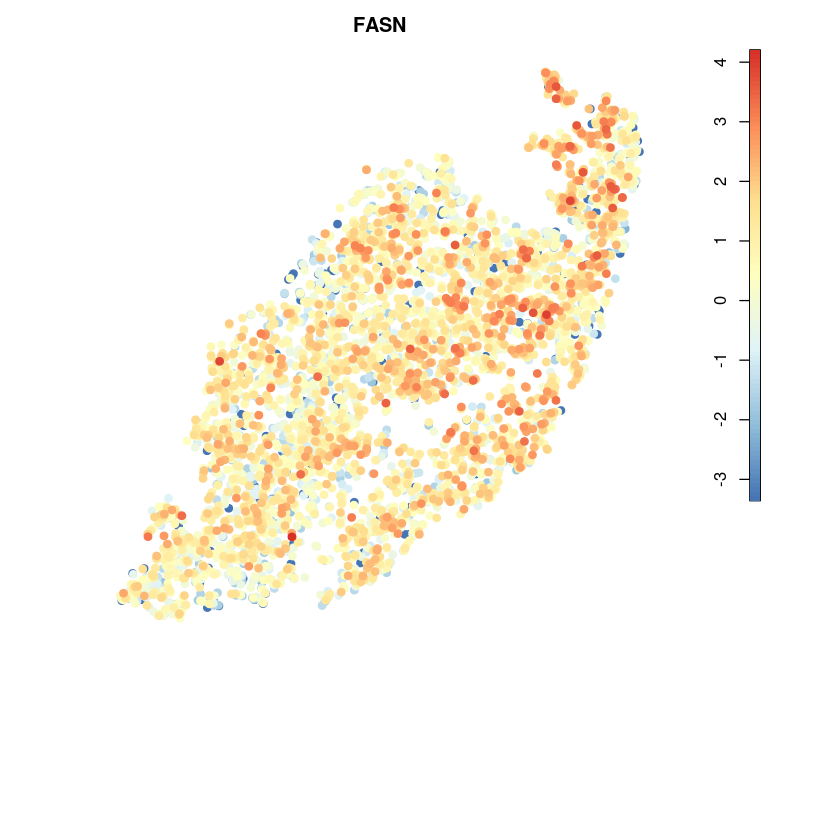

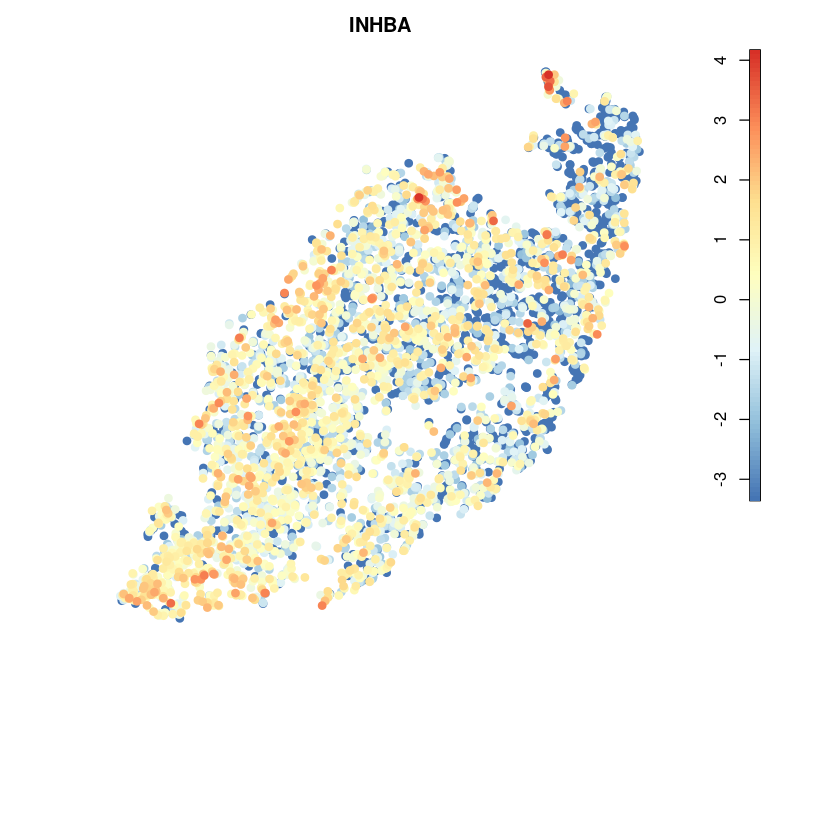

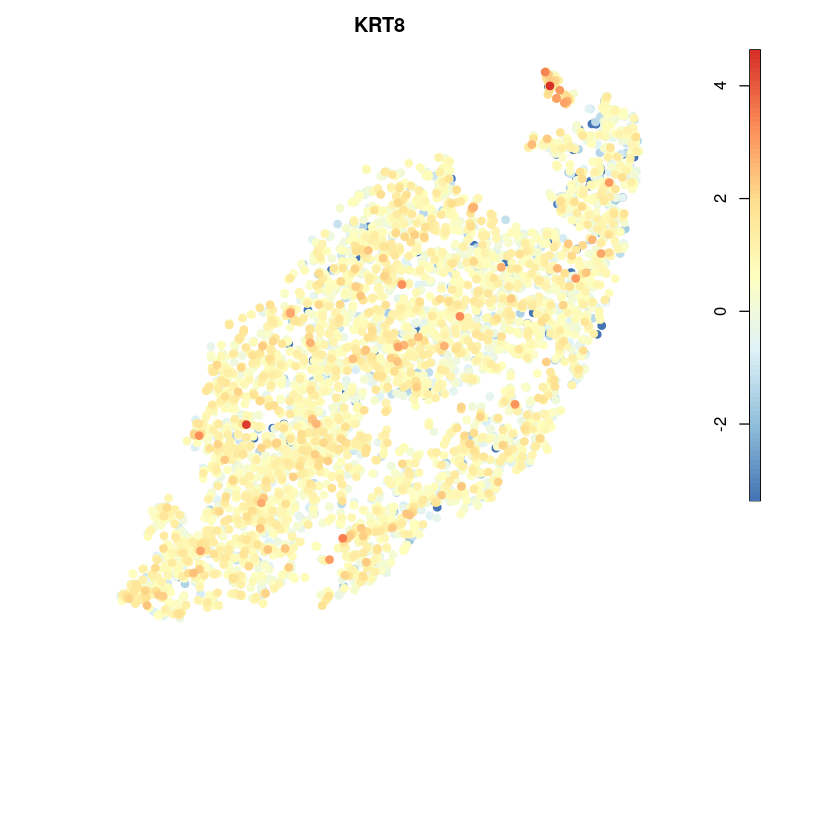

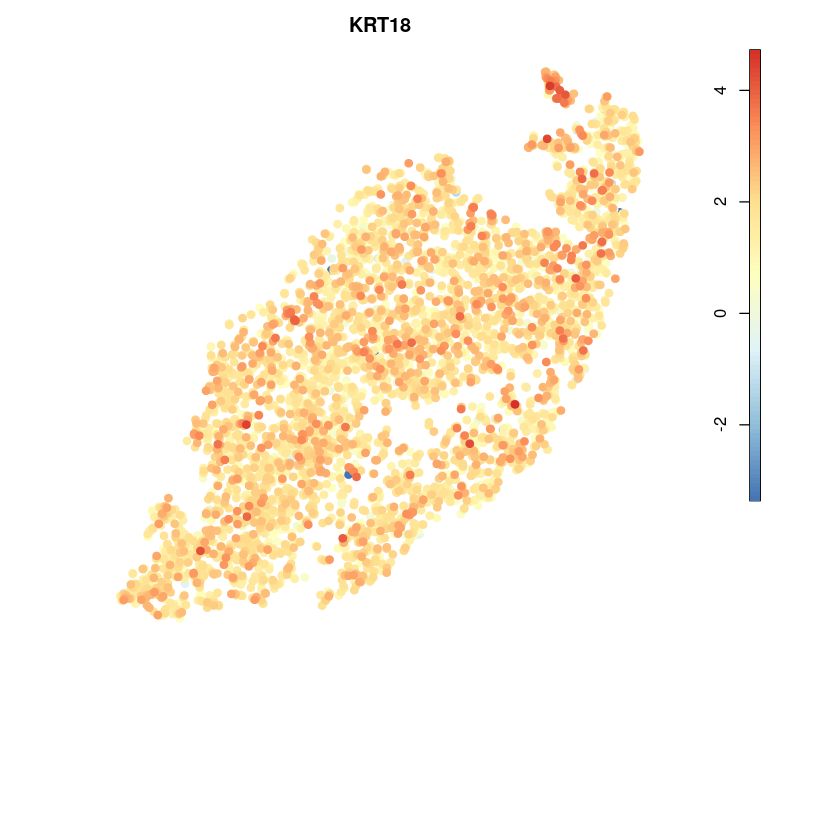

In [152]:
#plotmap(sin.sc)
plotexpmap(object = sin.sc, g = "FASN", logsc = T)
plotexpmap(object = sin.sc, g = "INHBA", logsc = T)
plotexpmap(object = sin.sc, g = "KRT8", logsc = T)
plotexpmap(object = sin.sc, g = "KRT18", logsc = T)

# New Analysis with CC removed

In [159]:
grep("^MT", new.names, value=T)

[1] "MTFR1L"   "MTX1"     "MTIF2"    "MTHFD2"   "MTLN"     "MTX2"    
 [7] "MTMR14"   "MTHFD2L"  "MTCH1"    "MTHFD1L"  "MTRF1L"   "MTURN"   
[13] "MTPN"     "MTDH"     "MTAP"     "MTRNR2L8" "MTCH2"    "MTIF3"   
[19] "MTA1"     "MT2A"     "MT1X"     "MTG2"     "MT-ND1"   "MT-ND2"  
[25] "MT-CO1"   "MT-CO2"   "MT-ATP6"  "MT-CO3"   "MT-ND3"   "MT-ND4"  
[31] "MT-ND5"   "MT-ND6"   "MT-CYB"